## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [3]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [4]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,0.006936,-0.040246,-0.003389,-0.003869
1,0.008102,0.010911,-0.008611,0.005732
2,-0.004191,-0.004786,-0.019372,0.015328
3,0.011583,-0.027195,-0.052457,0.024545
4,-0.113117,-0.010698,-0.065164,-0.074205


In [5]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00190130', u'US1MECM0086', u'USC00276368', u'US1NHMR0033', u'US1MELN0005']


,0,1,2,3
station,,,,
USC00190130,0.006936,-0.040246,-0.003389,-0.003869
US1MECM0086,0.008102,0.010911,-0.008611,0.005732
USC00276368,-0.004191,-0.004786,-0.019372,0.015328
US1NHMR0033,0.011583,-0.027195,-0.052457,0.024545
US1MELN0005,-0.113117,-0.010698,-0.065164,-0.074205


In [6]:
table=Eig.join(Stations,how='left')

In [7]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]#,4,5,6,7]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00190130,ANDOVER,42.6500,-71.1333,84.1,0.006936,-0.040246,-0.003389,-0.003869
US1MECM0086,POWNAL 4.1 S,43.8537,-70.1721,57.0,0.008102,0.010911,-0.008611,0.005732
USC00276368,NORTHWOOD,43.2000,-71.1500,164.9,-0.004191,-0.004786,-0.019372,0.015328
US1NHMR0033,BOSCAWEN 2.2 SE,43.2862,-71.6043,110.3,0.011583,-0.027195,-0.052457,0.024545


In [8]:
table[['latitude','longitude','elevation',0,1,2,3]].corr()

,latitude,longitude,elevation,0,1,2,3
latitude,1.000000,0.378997,0.174074,-0.130240,0.068610,0.065944,0.093967
longitude,0.378997,1.000000,-0.261052,0.003807,-0.062034,0.080112,0.066767
elevation,0.174074,-0.261052,1.000000,-0.057983,0.002954,-0.033624,0.029039
0,-0.130240,0.003807,-0.057983,1.000000,-0.596899,-0.210232,0.053827
1,0.068610,-0.062034,0.002954,-0.596899,1.000000,-0.211390,0.054123
2,0.065944,0.080112,-0.033624,-0.210232,-0.211390,1.000000,0.019063
3,0.093967,0.066767,0.029039,0.053827,0.054123,0.019063,1.000000


In [9]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = ['0000FF','00ff00','ff0000','ff0055','550055','005500','000000']
colors = ['blue','green','red','cyan','magenta','yellow','black']

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (42.6, 44.1, -71.8, -68.8)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

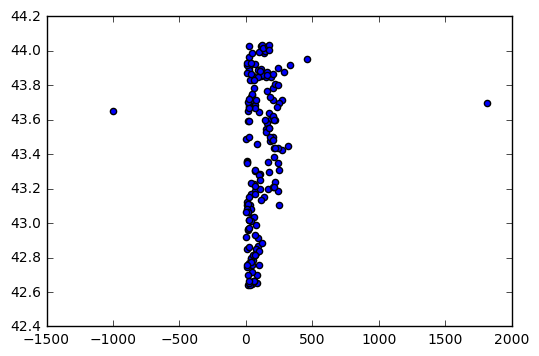

In [37]:
%matplotlib inline
plt.scatter(x=table['elevation'],y=table['latitude']);#'avg(coeff_1)');